# Get data from Tropomi (S5P) satellite and data analisis

In this Notebook we will develop a code for get an anaice data from S5p also we will 
learn abot print thos data at gmap usin lbraries like Geemap, geopandas and Earth engine api.

sugegsted links: 
- https://courses.spatialthoughts.com/end-to-end-gee.html#earth-engine-objects


First we eil import and initializate the GEE api

In [103]:
import os
import ee
import geemap
import geopandas as gdp
from ipyleaflet import GeoJSON
from zipfile import ZipFile
from geeS2downloader import GEES2Downloader
#ee.Authenticate()
ee.Initialize()


Now we will create a ImageCollection from S5P sensor, you could choose beetwen the following 
layers:


In [2]:
# Aviable layers:
# Se define la region de interes
# xMin = -65.654297
# yMin = -4.954507
# xMax = -82.573242
# yMax = 13.330474
# region = ee.Geometry.Rectangle(yMin, xMin,yMax, xMax)
# aoi1= ee.Geometry.Point([-74, 4.6])

methane = "COPERNICUS/S5P/OFFL/L3_CH4"
Municipios= ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level2")#Datos de fronteras a nivel municipal
Dep = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level1")#Filto de los anteriores datos para Colombia
Dep_col=Dep.filter(ee.Filter.eq('ADM0_NAME', 'Colombia'))#Datos de fronteras a nivel departamental
Mun_col=Municipios.filter(ee.Filter.eq('ADM0_NAME', 'Colombia'))#Filtro de los anteriores datos para Colombia
Fronteras=ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level0")#Datos de fronteras nacionales
#Front_col=Fronteras.filter(ee.Filter.eq('ADM0_NAME', 'Colombia'))#Filtro de los anteriores datos para Colombia
fronteras_maritimas = ee.FeatureCollection('projects/ee-jolejua/assets/EEZ_land_union_v3_202003')
Front_col=fronteras_maritimas.filter(ee.Filter.eq('UNION', 'Colombia'));
image1 = ee.ImageCollection(methane).select("CH4_column_volume_mixing_ratio_dry_air_bias_corrected").filterDate('2018-05-01', '2022-12-01')
imageC=ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_CLOUD").select('cloud_fraction').filterDate('2022-09-01', '2022-12-01')

imageNO2 = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_NO2').select('tropospheric_NO2_column_number_density').filterDate('2022-09-01', '2022-12-01');

imageSO2=ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_SO2").select('SO2_column_number_density').filterDate('2022-09-01', '2022-12-01');


# Map.setCenter(65.27, 24.11, 4);
#img_col= image1.first()
img1 = image1.mean()
img_col=img1.clip(Front_col)
imageC_col=imageC.mean()
img_col2=imageC_col.clip(Front_col)
#img_col = image1.first()

img_col_SO2=imageSO2.mean().clip(Front_col)
band_viz = {
    'min': 1600,
    'max': 2000,
    'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}

    
Map = geemap.Map(center=(4.6,-74),zoom=9)
#ap.setCenter(-74.297333, 4.570868,5)
#Map = geemap.Map(center=(-23, -48.4), zoom=9)

#Map.setCenter(-74.297333, 4.570868,5)
#imageNO2.getInfo()

In [55]:
col = ee.ImageCollection.fromImages([img1])
#col.getRegion()
#Map
#img_clus=img_col.cluster(ee.Clusterer.wekaCascadeKMeans(4,10))
# props = geemap.image_props(img_col)
# props.get('system:band_names').getInfo()
training=img_col.sample(region=Front_col.geometry(),scale=20000,factor=0.7,geometries=True)
#Map.addLayer(training, {}, 'training', False)

In [59]:
#Map.addLayer(img_clus, {}, 'Zonas',True,0.4)
n_clusters=3
clusterer = ee.Clusterer.wekaKMeans(n_clusters).train(training)
result = img_col.cluster(clusterer)

# # Display the clusters with random colors.
Map.addLayer(result.randomVisualizer(), {}, 'clusters')
Map

Map(bottom=16149.0, center=[5.867403444598711, -73.94919034917582], controls=(WidgetControl(options=['position…

In [53]:

Dep_col_s = Dep_col.style(fillColor='#FFFFFF80',
  width= 1.2)

Front_col_s = Front_col.style(  fillColor='b5ffb4',
  width=2);

#Map.addLayer(Front_col_s, {}, 'Colombia',True,0.5)

#Map.addLayer(img_col, band_viz, 'methane',True,1)
#Map.addLayer(img_col2, {'min': 0,'max': 0.75,
#    'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
#}, 'clouds',True,0.7)
#Map.addLayer(imageNO2.mean().clip(Front_col), {
 # 'min': 0,
  #'max': 0.00005,
  #'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']}, 'S5P N02',True,0.7);


Map.addLayer(Dep_col_s, {}, 'Departamentos',True,0.4)
Map.addLayer(Front_col_s, {}, 'Colombia',True,0.4)
#Map.addLayer(dataset, {}, 'Second Level Administrative Units',True,0.2)
Map.addLayer(img_col_SO2, {
  'min': 0,
  'max': 0.0009,
  'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']}, 'S5P S02',True,0.7);
Map

Map(center=[4.6, -74], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [54]:
Map1 = geemap.Map(center=(4.6,-74),zoom=9)
Map1.addLayer(imageNO2.mean().clip(Front_col), {
  'min': 0,
  'max': 0.00005,
  'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']}, 'S5P N02',True,0.7);
#Map1.addLayer(Dep_col_s, {}, 'Departamentos',True,0.4)
Map1

Map(center=[4.6, -74], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [55]:
Map2 = geemap.Map(center=(4.6,-74),zoom=5)
#Front_Yem=Fronteras.filter(ee.Filter.eq('ADM0_NAME', 'Yemen'))
img_y=img1.clip(Front_col)
Map2.addLayer(img_y, band_viz, 'methane',True,0.7);
Map2.addLayer(Front_col, {}, 'Frontera',True,0.1)
#Map2.addLayer(Dep_col_s, {}, 'Departamentos',True,0.4)
Map2

Map(center=[4.6, -74], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [34]:
Map3 = geemap.Map(center=(4.6,-74),zoom=5)
Map3.addLayer(imageC, {'min': 0,'max': 0.5,
    'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}, 'clouds',True,0.7)
Map3.addLayer(Dep_col_s, {}, 'Departamentos',True,0.4)
Map3

Map(center=[4.6, -74], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [50]:
#image1.getRegion(Front_col,scale=1).getInfo()
downloader = GEES2Downloader()

# call download method passing image and band (1 band at a time on this version)
downloader.download(img=img_d, band='CH4_column_volume_mixing_ratio_dry_air_bias_corrected')

NameError: name 'img_d' is not defined

In [8]:
aoi = ee.Geometry.Point([-48.4, -23])

clouds = ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY').filterDate('2019-11-25', '2019-11-28').filterBounds(aoi)

#img = s2.first()
cld = clouds.first()
Map = geemap.Map(center=(-23, -48.4), zoom=9)
Map.addLayer(cld, {'min': 0, 'max': 100, 'palette': ['purple', 'yellow']}, 'Cloud Probability', True, 1)
Map

Map(center=[-23, -48.4], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=…

In [2]:


# styleParams = {
#   fillColor: 'b5ffb4',
#   color: '00909F',
#   width: 1.0,
# };
#cld.getInfo()

In [142]:
# dataset = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level0");

# Map.setCenter(7.82, 49.1, 4);

# styleParams = {
#   fillColor='b5ffb4',
#   color='00909F',
#   width=1.0,
# }

# dataset = dataset.style(  fillColor='b5ffb4',
#   color='00909F',
#   width=2,);

Map.addLayer(dataset, {}, 'Country Boundaries',True,0.05);
Map

Map(bottom=1705.0, center=[49.1, 7.82], controls=(WidgetControl(options=['position', 'transparent_bg'], widget…

Map(bottom=8249.0, center=[5.331644153439766, -74.61914062500001], controls=(WidgetControl(options=['position'…

In [40]:
#extrema = img_col.reduce()
plane_data=img_col.reduceToVectors(ee.Reducer.mean(),Front_col.geometry())
plane_data.getInfo()
data=ee.batch.Export.table.toDrive(plane_data,fileFormat='GeoJSON')
# data?

EEException: Image.reduceToVectors: Need 1+1 bands for Reducer.mean, image has 1.

In [225]:
datai=image.toArray()
plane_data=datai.reduceToVectors()
#print(plane_data.getArray('name'))

import a shapefile and create his layer:
https://geemap.org/notebooks/65_vector_styling/#use-add_styled_vector

In [19]:
departamentos = ee.FeatureCollection('users/hmojica/data/departamentos')
style = {'color': '000000', 'width': 2, 'lineType': 'solid', 'fillColor': '00000000'}
Map.addLayer(departamentos.style(**style), {}, "Departamentos")



#### ee.ImageCollection.mean
Reduces an image collection by calculating the mean of all values at each pixel across the stack of all matching bands. Bands are matched by name.

In [9]:
band_viz = {
    'min': 1750,
    'max': 1900,
    'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}
Map.addLayer(image.mean(), band_viz, 'methane')
Map.setCenter(-74.297333, 4.570868, 5);

# Se define la region de interes
xMin = -65.654297
yMin = -4.954507
xMax = -82.573242
yMax = 13.330474
region = ee.Geometry.Rectangle([
    [xMin, yMin],
    [xMax, yMax]
  ])

In [90]:
# se obtiene las coordenadas de la región dibujndo la region con un poligono
#region = Map.user_roi #.getInfo()
#print(region)
mean=image.mean()
type(mean.toArray())

ee.image.Image

In [11]:
#Map.addLayer(image.mean(), band_viz, 'S5P Cloud')
#geemap.clip_image(Map, region, Map)


El resultado de dibujar el poligono y obtener las coordenadas es un json:

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              -82.573242,
              -4.954507
            ],
            [
              -82.573242,
              13.330474
            ],
            [
              -65.654297,
              13.330474
            ],
            [
              -65.654297,
              -4.954507
            ],
            [
              -82.573242,
              -4.954507
            ]
          ]
        ]
      }
    }
  }
})


In [14]:
# Mosaic the visualization layers and display (or export).
mosaic = image.mosaic()
# Map.addLayer(mosaic, {}, 'mosaic', False)

# Create a circle by drawing a 20000 meter buffer around a point.
clipped = mosaic.clip(region)

# Display a clipped version of the mosaic.
band_viz = {
    'min': 0,
    'max': 0.95,
    'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}
Map.addLayer(clipped, band_viz, 'Clipped image')

# Display the map
Map

Map(bottom=4292.0, center=[4.570868, -74.297333], controls=(WidgetControl(options=['position', 'transparent_bg…

In [12]:
ee.Export?

Object `ee.Export` not found.


In [3]:
shp=gdp.read_file('EEZ_land_union_v3_202003/EEZ_Land_v3_202030.shp')
num_df.loc[num_df['a'] == 2]

<AxesSubplot: >

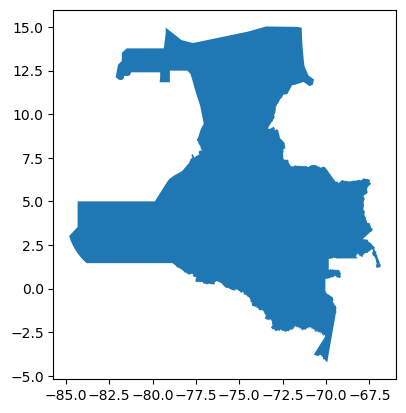

In [12]:
# var shp=ee.FeatureCollection(polygon);
# var colombiam=shp.filter(ee.Filter.eq('UNION', 'Colombia'));
# //Map.addLayer(colombiam,{})
# Map
shp.loc[shp['UNION']=='Colombia'].plot()

In [208]:
#shp['TERRITORY1'].unique()
#Crear gif
from datetime import datetime
import numpy as np
from dateutil.relativedelta import relativedelta
from geemap import cartoee
s_date='2019-02-08' #Primera fecha disponible en el satelite
e_date='2019-03-08'
#np.datetime64(e_date)+ np.timedelta64(1, 'M')
imagenes=[]
date=[]
for i in range (48): #Hay que contar el número de meses disponibles
    image1 = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_CH4").select("CH4_column_volume_mixing_ratio_dry_air_bias_corrected").filterDate(s_date, e_date)
    #Cambiar en image1 la banda y el satélite
    img1 = image1.mean()
    img_col=img1.clip(Front_col)
    imagenes.append(img_col)
    date.append(s_date)
    s_date=e_date
    new_e=datetime.strptime(e_date, '%Y-%m-%d')+ relativedelta(months=1)
    e_date=str(new_e)
    e_date=e_date.split()[0]
   

In [209]:
collection=ee.ImageCollection.fromImages(imagenes)
vis_params = {    'min': 1600, 'max': 2000,'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']}
#Arreglar límites para la emisión
image = ee.Image(collection.first())
Mapg = geemap.Map(center=(4.6,-74),zoom=5.3)
Mapg.addLayer(image, vis_params, 'First image',True,0.9)
Mapg

Map(center=[4.6, -74], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [213]:
aoi = ee.Geometry.Polygon(
    [[[-85.0, 16.0], [-85.0, -5.5], [-65.8, -5.5], [-65.8, 16.0]]], None, False
)

# SO2Col = (
#     ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_SO2")
#     .filterDate('2019-12-22', '2019-12-25')
#     .limit(24)
#     .select('SO2_column_number_density')
# )

# Define arguments for animation function parameters.
videoArgs = {

    'region': aoi,
    'framesPerSecond': 1,
    'crs': 'EPSG:3857',
    "min":  1600, #Cambiar límite
    "max": 2000, #Cambiar límite
    'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red'],
}

In [214]:
saved_gif = os.path.join(os.path.expanduser('~'), 'Documentos/GEE_python/CH4.gif') #Cambiar el nombre del archivo
geemap.download_ee_video(collection, videoArgs, saved_gif)

Generating URL...
Please wait ...
The GIF image has been saved to: /home/julian/Documentos/GEE_python/CH4.gif


In [215]:
geemap.show_image(saved_gif)
#geemap.download_ee_video?

Output()

In [205]:
text = [str(n).zfill(2) + ":00" for n in range(0, 24)]
print(text)
print(date)

['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00', '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00']
['2018-12-20', '2019-01-20', '2019-02-20', '2019-03-20', '2019-04-20', '2019-05-20', '2019-06-20', '2019-07-20', '2019-08-20', '2019-09-20', '2019-10-20', '2019-11-20', '2019-12-20', '2020-01-20', '2020-02-20', '2020-03-20', '2020-04-20', '2020-05-20', '2020-06-20', '2020-07-20', '2020-08-20', '2020-09-20', '2020-10-20', '2020-11-20', '2020-12-20', '2021-01-20', '2021-02-20', '2021-03-20', '2021-04-20', '2021-05-20', '2021-06-20', '2021-07-20', '2021-08-20', '2021-09-20', '2021-10-20', '2021-11-20', '2021-12-20', '2022-01-20', '2022-02-20', '2022-03-20', '2022-04-20', '2022-05-20', '2022-06-20', '2022-07-20', '2022-08-20', '2022-09-20', '2022-10-20', '2022-11-20', '2022-12-20', '2023-01-20']


In [216]:
out_gif = os.path.join(os.path.expanduser('~'), 'Documentos/GEE_python/output_CH4.gif') #Cmbiar nombre de gas

In [217]:
geemap.add_text_to_gif(
    saved_gif,
    out_gif,
    xy=('3%', '5%'),
    text_sequence=date,
    font_size=30,
    font_color='#ffffff',
)

In [218]:
geemap.add_text_to_gif(
    out_gif,
    out_gif,
    xy=('32%', '92%'),
    font_color='white',
)

In [219]:
geemap.show_image(out_gif)

Output()